# "Entity Extraction (NER) - Training and Inference using Transformers - Part 3"
> Learn to train a NER model using Transformers Trainer Class, and to run Inference using Pipeline function

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [nlp, token classification]
- image: images/transformers-ner-part1.png
- hide: false

In the [previous post](http://forgetfulcrow.com/nlp/token%20classification/2020/09/19/_09_20_Entity_Extraction_Transformers_Part_2.html) we trained the NER model on a kaggle dataset. 

In this post we will train an Entity Extraction model on a MIT restaurant Intent dataset. These dataset is helpful for slot filling in the chatbot conversations. The model will be able to recognize following entities

`Rating`  
`Dish`  
`Location`  


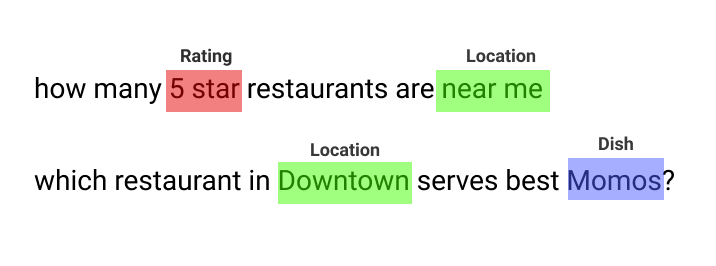

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==3.1.0
!pip install seqeval
!pip install conllu

## Download the Restaurant Intent Dataset

In [ ]:
!wget https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttrain.bio 
!wget https://groups.csail.mit.edu/sls/downloads/restaurant/restauranttest.bio 

The data is present in the following format 

`O`	a  
`B-Rating`	four     
`I-Rating`	star    
`O`	restaurant    
`B-Location`	with  
`I-Location`	a  
`B-Amenity`	bar

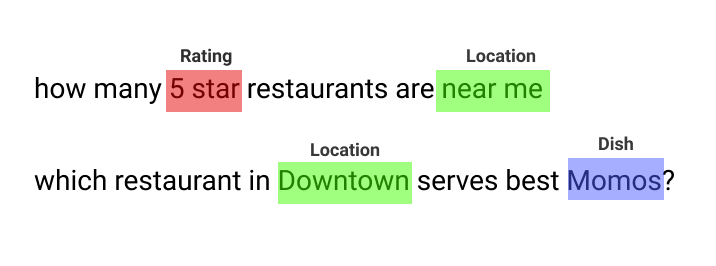

### Convert datafile to conllu input format for processing with [NER Task Class](https://github.com/huggingface/transformers/blob/4f6e52574248636352a746cfe6cc0b13cf3eb7f9/examples/token-classification/tasks.py)

1. Reverse the tag and the column column in both the test and train files.

2. Replace the tab seperator to space.

3. Change the example seperator to newline

In [ ]:
!awk '{print $2,$1}' restauranttest.bio > "/content/drive/My Drive/transformers-ner/mit-restaurant-data/test.txt"
!awk '{print $2,$1}' restauranttrain.bio > "/content/drive/My Drive/transformers-ner/mit-restaurant-data/train.txt"
!sed -i 's/\t/ /g' '/content/drive/My Drive/transformers-ner/mit-restaurant-data/test.txt' 
!sed -i 's/^ $/\n/g' '/content/drive/My Drive/transformers-ner/mit-restaurant-data/test.txt'
!sed -i 's/\t/ /g' '/content/drive/My Drive/transformers-ner/mit-restaurant-data/train.txt' 
!sed -i 's/^ $/\n/g' '/content/drive/My Drive/transformers-ner/mit-restaurant-data/train.txt'

In [ ]:
import pandas as pd 
df = pd.read_csv('/content/drive/My Drive/transformers-ner/mit-restaurant-data/train.txt',sep=' ', header=None)

In [ ]:
with open('/content/drive/My Drive/transformers-ner/mit-restaurant-data/labels.txt','w') as fout:
  for tag in df[1].unique():
    fout.write(tag+'\n')

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/utils_ner.py
!wget https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/run_ner.py
!wget https://raw.githubusercontent.com/huggingface/transformers/v3.1.0/examples/token-classification/tasks.py

## Run the Training Code

In [ ]:
!python run_ner.py  --model_name_or_path 'roberta-base'  \
--data_dir '/content/drive/My Drive/transformers-ner/mit-restaurant-data/' \
--output_dir 'restaurant-model' \
--max_seq_length '128' \
--num_train_epochs 3 \
--per_device_train_batch_size 8 \
--save_steps 1000000 \
--seed 16 \
--do_train \
--do_predict \
--overwrite_output_dir \
--labels "/content/drive/My Drive/transformers-ner/mit-restaurant-data/labels.txt" \
--fp16

The model training achieves an accuracy score of 91% on the test dataset.

eval_loss = 0.29688322173849724  
eval_accuracy_score = 0.9196127946127947  
eval_precision = 0.7854288349216109    
eval_recall = 0.8108536972389717  
eval_f1 = 0.7979387882573391

## Model Prediction

Run the prediction using the pipeline class

In [ ]:
from transformers import pipeline
model_name = '/content/restaurant-model'
nlp = pipeline(task="ner", model=model_name, tokenizer=model_name, framework="pt",grouped_entities=True)

In [ ]:
sequence =["""how many 5 star restaurants are near me.""","Which restaurant in Downtown serves best Momos?"]
nlp(sequence)

[[{'entity_group': 'B-Rating', 'score': 0.9906011819839478, 'word': ' 5 star'},
  {'entity_group': 'B-Location',
   'score': 0.927771806716919,
   'word': ' near me'}],
 [{'entity_group': 'B-Location',
   'score': 0.6126553416252136,
   'word': ' in Downtown'},
  {'entity_group': 'B-Rating', 'score': 0.9742729663848877, 'word': ' best'},
  {'entity_group': 'B-Dish', 'score': 0.990350604057312, 'word': ' Momos'}]]